In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import math
import torch
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

KB = 8.6173303e-5
h = 4.1356692e-15 # eV⋅s
h_b = h/2*np.pi
c = 3e8 # m/s

In [ ]:
def open_file(filepath):
    with open(filepath, 'r+') as f:
        full_raw_pl = f.read()

    headers = np.array(full_raw_pl.split('\n'))[0]
    headers = headers.split('\t')[1:]
    headers = (np.array(headers, dtype=float))

    full_raw_pl = np.array(full_raw_pl.split('\n'))[1:]
    full_raw_pl = np.array([i.split('\t') for i in full_raw_pl if len(i)>0], dtype=float)

    pl = full_raw_pl[:, 1:]
    baseline = True
    if baseline:
        pl = pl - np.min(pl, axis=0)

    wavelength = full_raw_pl[:, 0]

    return headers, wavelength, pl

GaAs_headers, GaAs_wavelength, GaAs_pl = open_file('2024_Aug_10_GaAs_Wafer_v2_NoCover.txt')
BCP_headers, BCP_wavelength, BCP_pl = open_file('2024_Jul_15_BCP_NoCover.txt')

def get_FWHM(pls, wavelength, start, end, minss, plot=True, is_power=False):

    n_wls = []
    n_pls = []

    for index, pl in enumerate(pls.T):
        
        if is_power:
            n_pl = pl[start:end]
            n_wl = wavelength[start:end]
        else:
            n_pl = pl[start - index*minss:end - index*minss]
            n_wl = wavelength[start - index*minss:end - index*minss]
       
        n_pl *= 3  # integration time in sec
        n_pl *= 2.01e8  #*(1240/n_wl) # counts to photons
        n_pl /= 532 * 134 * 1e-12  # area in m^2
        n_pls.append(n_pl)
        n_wls.append(n_wl)

        if plot:
            plt.plot(n_wl, n_pl)
            plt.ylabel('Absolute Intensity (photons)')
            plt.xlabel(r'Wavenelgth (nm)')

    return n_pls, n_wls

GaAs_n_pls, GaAs_n_wls = get_FWHM(GaAs_pl[:, 0:], GaAs_wavelength[0:], 600, 1250, 50, plot=True, is_power=True)
BCP_n_pls, BCP_n_wls = get_FWHM(BCP_pl[:, 0:], BCP_wavelength[0:], 600, 1100, 50, plot=True, is_power=True)

In [ ]:
@cuda.jit(device=True)
def T_D(ex, eg, eu, th): 
    return (1/(2 * eu)) * math.exp(-((abs((ex-eg)/eu))**th))

@cuda.jit(device=True)
def G_s(ep, eg, eu, th, ex):
    return T_D(ep, 0, eu, th) * math.sqrt((ex - eg) - ep)

@cuda.jit(device=True)
def G(a, b, n, eg, eu, th, ex):

    h = (b - a) / n

    integral = 0.5 * G_s(a, eg, eu, th, ex) + 0.5 * G_s(b, eg, eu, th, ex)
    for i in range(1, n):
        integral += G_s(a + i * h, eg, eu, th, ex)
    integral *= h
    
    return integral

@cuda.jit(device=True)
def alpha_s(eg, eu, th, ex, alpha_0):
    return G(-eg, ex - eg, 1000, eg, eu, th, ex) * alpha_0

@cuda.jit(device=True)
def ed(ex, ef, kt, option=3):
    if option==1:
        return 1 - (2 / (math.exp((ex - ef)/(2 * kt)) + 1))
    elif option == 2:
        return (math.exp((ex - ef)/kt) - math.exp(-ex/kt)) / (math.exp((ex - ef)/kt) + math.exp(-ex/kt) + math.exp((- ef)/kt) + 1)
    elif option == 3:
        return 0.5 - (1 / (math.exp((ex - ef)/(1 * kt)) + 1))

@cuda.jit(device=True)
def a_s(eg, eu, th, ex, alpha_0, ef, kt):
    return 1 - math.exp(-alpha_s(eg, eu, th, ex, alpha_0) * ed(ex, ef, kt))

@cuda.jit(device=True)
def I_sn(eg, ex, eu, alpha_0, kt, ef, th):
    return (2 * math.pi / ((h**3) * (c**2))) * ((ex**2)/(math.exp((ex - ef)/(kt)) - 1)) * a_s(eg, eu, th, ex, alpha_0, ef, kt)

@cuda.jit
def pl_kernel(hvs, pred, eg, eu, alpha_0, kt, ef, th):
    col, row = cuda.grid(2)

    if row < hvs.shape[0] and col < hvs.shape[1]:

        pred[row, col] = I_sn(eg[0], hvs[row, col], eu[0], alpha_0[row], kt[0], ef[row], th[0])

@cuda.jit(device=True)
def temp_ed(ex, ef, eh, kt):
    return (1 - 1/(math.exp((ex - eh)/kt) + 1)) - (1/(math.exp((ex - ef)/kt) + 1))

@cuda.jit(device=True)
def temp_a_s(eg, eu, th, ex, alpha_0, ef, eh, kt):
    return 1 - math.exp(-alpha_s(eg, eu, th, ex, alpha_0) * temp_ed(ex, ef, eh, kt))

@cuda.jit(device=True)
def temp_I_sn(eg, ex, eu, alpha_0, kt, ef, eh, th):
    # eh=0
    return (2 * math.pi / ((h**3) * (c**2))) * ((ex**2)/(math.exp((ex - (ef - eh))/(kt)) - 1)) * temp_a_s(eg, eu, th, ex, alpha_0, ef, eh, kt)

@cuda.jit
def pl_kernel(hvs, pred, eg, eu, alpha_0, kt, ef, eh, th):
    col, row = cuda.grid(2)

    if row < hvs.shape[0] and col < hvs.shape[1]:

        pred[row, col] = temp_I_sn(eg[0], hvs[row, col], eu[0], alpha_0[row], kt[0], ef[row], eh[row], th[0])


In [ ]:
def nii(temp, Eg=1.42, N_D=3e22, dn=1e20, m_e=0.063, m_h=0.51, doped=True):
    k = 1.380649e-23
    h = 6.626e-34
    m0 = 9.109e-31
    KB = 8.6173303e-5

    T = temp
    m_e_star = m_e * m0
    m_h_star = m_h * m0

    Nc = 2 * ((2 * np.pi * m_e_star * k * T / (h**2))**(3/2))
    Nv = 2 * ((2 * np.pi * m_h_star * k * T / (h**2))**(3/2))

    ni = np.sqrt(Nc * Nv * np.exp(-Eg/(KB*T)))
    
    
    if doped:

        n0 = N_D
        p0 = (ni**2/N_D)

        Efe = Eg - KB * T * np.log(Nc/(n0 + dn))
        Efh = KB * T * np.log(Nv/(p0 + dn))

    else:

        n0 = ni
        p0 = ni

        Efe = Eg - KB * T * np.log(Nc/(n0 + dn))
        Efh = KB * T * np.log(Nv/(p0 + dn))
    return Efe, Efh

nii(300, Eg=1.4543, dn=0, m_e=0.02, m_h=0.51, doped=True)

In [ ]:
device = torch.device("cuda") 

ints = torch.from_numpy(np.array(GaAs_n_pls[:1]))
ints = ints.to(device)

hvs = torch.from_numpy(1240/np.array(GaAs_n_wls[:1]))
hvs = hvs.to(device)
hvs = cuda.as_cuda_array(hvs)
pred = cuda.device_array_like(hvs)

r_alpha_0 = cuda.as_cuda_array(torch.tensor([25], device=device))
r_Eg = cuda.as_cuda_array(torch.tensor([1.42], device=device))
r_Ef = cuda.as_cuda_array(torch.tensor([nii(300, Eg=1.42, dn=5e17)[0]], device=device))
r_Eu = cuda.as_cuda_array(torch.tensor([0.0088], device=device))
r_KT = cuda.as_cuda_array(torch.tensor([KB * 330], device=device))
r_Th = cuda.as_cuda_array(torch.tensor([1.0], device=device))

r_Eh = cuda.as_cuda_array(torch.tensor([nii(300, Eg=1.42, dn=5e17)[1]], device=device))

threads_per_block = (16, 16)
blocks_per_grid = 2048

pl_kernel[blocks_per_grid, threads_per_block](hvs, pred, r_Eg, r_Eu, r_alpha_0, r_KT, r_Ef, r_Eh, r_Th)
temp = torch.as_tensor(pred, device='cuda')

pred = temp #*4.65e-39

Iss = pred.to('cpu').numpy() 
plt.plot(1240/np.array(GaAs_n_wls[0]), Iss[0])#/np.max(Iss[-1]))
plt.plot(1240/np.array(GaAs_n_wls[0]), GaAs_n_pls[0])#/np.max(GaAs_n_pls[-1]))

In [ ]:
def GaAs_fun(x, 
              eu, eg, 
              ee1, ee2, ee3, ee4, ee5, ee6, ee7, ee8, ee9, 
              d1, kt, theta):
    

    device = torch.device("cuda") 
    theta=3.5e22
    eg=1.425

    ee1, eh1 = nii(kt, Eg=eg, N_D=theta, dn=ee1)
    ee2, eh2 = nii(kt, Eg=eg, N_D=theta, dn=ee2)
    ee3, eh3 = nii(kt, Eg=eg, N_D=theta, dn=ee3)
    ee4, eh4 = nii(kt, Eg=eg, N_D=theta, dn=ee4)
    ee5, eh5 = nii(kt, Eg=eg, N_D=theta, dn=ee5)
    ee6, eh6 = nii(kt, Eg=eg, N_D=theta, dn=ee6)
    ee7, eh7 = nii(kt, Eg=eg, N_D=theta, dn=ee7)
    ee8, eh8 = nii(kt, Eg=eg, N_D=theta, dn=ee8)
    ee9, eh9 = nii(kt, Eg=eg, N_D=theta, dn=ee9)

    hvs = torch.from_numpy(1240/np.array(x))
    hvs = hvs.to(device)
    hvs = cuda.as_cuda_array(hvs)
    pred = cuda.device_array_like(hvs)

    eu, eg, kt = [cuda.as_cuda_array(torch.tensor([i], device=device)) for i in [eu, eg, KB * kt]]

    ee = cuda.as_cuda_array(torch.tensor([ee1, ee2, ee3, ee4, ee5, ee6, ee7, ee8, ee9], device=device))
    eh = cuda.as_cuda_array(torch.tensor([eh1, eh2, eh3, eh4, eh5, eh6, eh7, eh8, eh9], device=device))
    d = cuda.as_cuda_array(torch.tensor([d1, d1, d1, d1, d1, d1, d1, d1, d1], device=device))

    pl_kernel[blocks_per_grid, threads_per_block](hvs, pred, eg, eu, d, kt, ee, eh, cuda.as_cuda_array(torch.tensor([1], device=device)))
    spectra_combined = torch.as_tensor(pred, device='cuda') 
   
    return 1*spectra_combined.to('cpu').numpy().flatten()

device = torch.device("cuda") 

intsA = np.array(GaAs_n_pls[:9])
hvsA = np.array(GaAs_n_wls[:9])

initial_guesses = {'eu':0.009, 'eg':1.425, 
                    'ef1':1e20, 'ef2':1e20, 'ef3':1e20,
                    'ef4':1e20, 'ef5':1e20, 'ef6':1e20,
                    'ef7':1e20, 'ef8':1e20, 'ef9':1e20,
                    'd1':2, 'kt':330, 'theta':3.5e22}

GaAs_popt_f, _ = curve_fit(GaAs_fun, hvsA, intsA.flatten(), p0=list(initial_guesses.values()), maxfev=8_000)
intensity_pred_f = GaAs_fun(hvsA, *GaAs_popt_f)
r2_f = r2_score(intsA.flatten(), intensity_pred_f)

print(f"R^2 = {r2_f}", [f"{list(initial_guesses.keys())[index]} = {p}" for index, p in enumerate(GaAs_popt_f)])

In [ ]:
efe, efh = nii(abs(GaAs_popt_f[20]), Eg=abs(GaAs_popt_f[1]), dn=abs(GaAs_popt_f[2:11]), N_D=abs(GaAs_popt_f[-2]))
abs(GaAs_popt_f[2:11]), abs(efe-efh)

In [ ]:
def BCP_fun(x, 
             euA, egA, 
             e1A, e2A, e3A, e4A, e5A, e6A, e7A, e8A, e9A, 
             d1A,
             euB, egB, 
             meA, mh, meB,
             fit, kt,
             isolate=0):
    
    ee1A, eh1A = nii(kt, Eg=egA, dn=e1A, m_e=meA, m_h=mh, doped=False)
    ee2A, eh2A = nii(kt, Eg=egA, dn=e2A, m_e=meA, m_h=mh, doped=False)
    ee3A, eh3A = nii(kt, Eg=egA, dn=e3A, m_e=meA, m_h=mh, doped=False)
    ee4A, eh4A = nii(kt, Eg=egA, dn=e4A, m_e=meA, m_h=mh, doped=False)
    ee5A, eh5A = nii(kt, Eg=egA, dn=e5A, m_e=meA, m_h=mh, doped=False)
    ee6A, eh6A = nii(kt, Eg=egA, dn=e6A, m_e=meA, m_h=mh, doped=False)
    ee7A, eh7A = nii(kt, Eg=egA, dn=e7A, m_e=meA, m_h=mh, doped=False)
    ee8A, eh8A = nii(kt, Eg=egA, dn=e8A, m_e=meA, m_h=mh, doped=False)
    ee9A, eh9A = nii(kt, Eg=egA, dn=e9A, m_e=meA, m_h=mh, doped=False)

    ee1B, eh1B = nii(kt, Eg=egB, dn=e1A, m_e=meB, m_h=mh, doped=False)
    ee2B, eh2B = nii(kt, Eg=egB, dn=e2A, m_e=meB, m_h=mh, doped=False)
    ee3B, eh3B = nii(kt, Eg=egB, dn=e3A, m_e=meB, m_h=mh, doped=False)
    ee4B, eh4B = nii(kt, Eg=egB, dn=e4A, m_e=meB, m_h=mh, doped=False)
    ee5B, eh5B = nii(kt, Eg=egB, dn=e5A, m_e=meB, m_h=mh, doped=False)
    ee6B, eh6B = nii(kt, Eg=egB, dn=e6A, m_e=meB, m_h=mh, doped=False)
    ee7B, eh7B = nii(kt, Eg=egB, dn=e7A, m_e=meB, m_h=mh, doped=False)
    ee8B, eh8B = nii(kt, Eg=egB, dn=e8A, m_e=meB, m_h=mh, doped=False)
    ee9B, eh9B = nii(kt, Eg=egB, dn=e9A, m_e=meB, m_h=mh, doped=False)

    device = torch.device("cuda")

    hvs = torch.from_numpy(1240/np.array(x))
    hvs = hvs.to(device)
    hvs = cuda.as_cuda_array(hvs)

    pred = cuda.device_array_like(hvs)
    pred2 = cuda.device_array_like(hvs)

    euA, egA, euB, egB, kt = [cuda.as_cuda_array(torch.tensor([i], device=device)) for i in [euA, egA, euB, egB, KB * kt]]
    dA = cuda.as_cuda_array(torch.tensor([d1A, d1A, d1A, d1A, d1A, d1A, d1A, d1A, d1A], device=device))
    
    eeA = cuda.as_cuda_array(torch.tensor([ee1A, ee2A, ee3A, ee4A, ee5A, ee6A, ee7A, ee8A, ee9A], device=device))
    eeB = cuda.as_cuda_array(torch.tensor([ee1B, ee2B, ee3B, ee4B, ee5B, ee6B, ee7B, ee8B, ee9B], device=device))

    ehA = cuda.as_cuda_array(torch.tensor([eh1A, eh2A, eh3A, eh4A, eh5A, eh6A, eh7A, eh8A, eh9A], device=device))
    ehB = cuda.as_cuda_array(torch.tensor([eh1B, eh2B, eh3B, eh4B, eh5B, eh6B, eh7B, eh8B, eh9B], device=device))
    
    pl_kernel[blocks_per_grid, threads_per_block](hvs, pred, egA, euA, dA, kt, eeA, ehA, cuda.as_cuda_array(torch.tensor([1], device=device)))
    spectra_combined = torch.as_tensor(pred, device='cuda')

    if isolate == 1:
        return  fit*spectra_combined.to('cpu').numpy().flatten()

    pl_kernel[blocks_per_grid, threads_per_block](hvs, pred2, egB, euB, dA, kt, eeB, ehB, cuda.as_cuda_array(torch.tensor([1], device=device)))
    spectra_combined += torch.as_tensor(pred2, device='cuda')

    if isolate == 2:
        return  fit*torch.as_tensor(pred2, device='cuda').to('cpu').numpy().flatten()
   
    return  fit*spectra_combined.to('cpu').numpy().flatten()

device = torch.device("cuda") 

ints = np.array(GaAs_n_pls[-9:])
hvs = np.array(GaAs_n_wls[-9:])
cc=1e21
initial_guesses = {'euA':0.01, 'egA':1.44, 
                   'ef1A':cc, 'ef2A':cc, 'ef3A':cc, 'ef4A':cc, 'ef5A':cc, 'ef6A':cc, 'ef7A':cc, 'ef8A':cc, 'ef9A':cc,
                   'd1A':0.1161,

                   'euB':0.01, 'egB':1.46,
                   'meA':0.11, 'mh':0.45, 'meB':0.11,

                   'fit':3.72,
                   'kt':344}

BCP_popt_f, _ = curve_fit(BCP_fun, hvs, ints.flatten(),p0=list(initial_guesses.values()), maxfev=8_000)
intensity_pred_f = BCP_fun(hvs, *BCP_popt_f)

r2_f = r2_score(ints.flatten(), intensity_pred_f)
print(f"R^2 = {r2_f}", [f"{list(initial_guesses.keys())[index]} = {p}" for index, p in enumerate(BCP_popt_f)])

In [ ]:
mh, meA, meB, temp, EgA, EgB = BCP_popt_f[23], BCP_popt_f[22], BCP_popt_f[24], BCP_popt_f[26], BCP_popt_f[1], BCP_popt_f[21]
efe, efh = nii(abs(temp), Eg=abs(EgA), dn=abs(BCP_popt_f[2:11]), doped=False, m_e=abs(meA), m_h=abs(mh))
BCP_popt_f[2:11], efe-efh

In [ ]:
efe, efh = nii(abs(temp), Eg=abs(EgB), dn=abs(BCP_popt_f[2:11]), doped=False, m_e=abs(meB), m_h=abs(mh))
BCP_popt_f[2:11], efe-efh

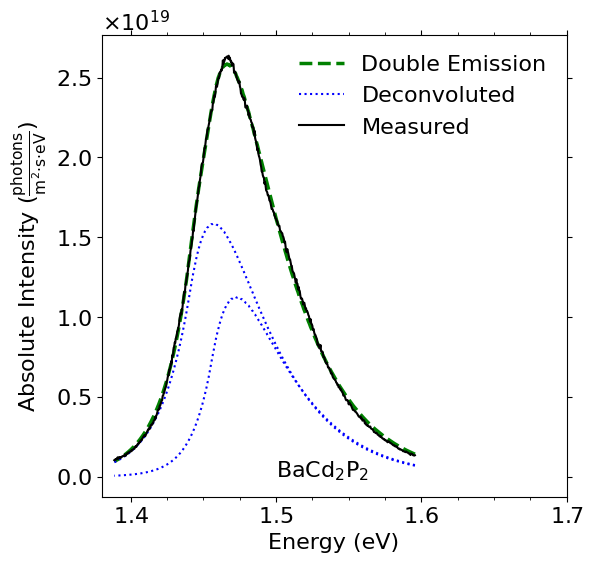

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)
plt.rcParams.update({'font.size': 16})


BCP_sample = -1
ax.plot(1240/np.array(hvs[BCP_sample]), BCP_fun(hvs, *BCP_popt_f).reshape(ints.shape)[BCP_sample], linewidth=2.5, linestyle='--', color='green', label='Double Emission')
ax.plot(1240/np.array(hvs[BCP_sample]), BCP_fun(hvs, *BCP_popt_f, isolate=1).reshape(ints.shape)[BCP_sample], ':', color='blue', label='Deconvoluted')
ax.plot(1240/np.array(hvs[BCP_sample]), BCP_fun(hvs, *BCP_popt_f, isolate=2).reshape(ints.shape)[BCP_sample], ':', color='blue')
ax.plot(1240/(hvs[BCP_sample]), ints[BCP_sample], color='black', label='Measured')
ax.legend(frameon=False, loc='upper right', prop={'size': 14})

ax.set_xlabel(r'Energy (eV)')
ax.legend(frameon=False, loc='upper right')
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.025))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5e19))
ax.tick_params(which='both', top=True, bottom=True, left=True, right=True)

ax.set_ylabel(r'Absolute Intensity ($\frac{\mathsf{photons}}{\mathsf{m^2{\cdot}s{\cdot}eV}}$)')
ax.text(1.5, 0, r'BaCd$_{\rm 2}$P$_{\rm 2}$', fontsize = 16)

show_GaAs = False
if show_GaAs:
    GaAs_sample = -1
    ax.plot(1240/np.array(hvsA[GaAs_sample]), GaAs_fun(hvsA, *GaAs_popt_f).reshape(intsA.shape)[GaAs_sample], linewidth=2.5, linestyle='--', color='red', label='Single Emission')
    ax.plot(1240/(hvsA[GaAs_sample]), intsA[GaAs_sample], color='black', label='Measured')
    ax.legend(frameon=False, loc='upper right', prop={'size': 14})

    ax.set_xlabel(r'Energy (eV)')
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.025))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(10e20))
    ax.tick_params(which='both', top=True, bottom=True, left=True, right=True)
    ax.legend(frameon=False, loc='upper right')

    ax.set_ylabel(r'Absolute Intensity ($\frac{\mathsf{photons}}{\mathsf{m^2{\cdot}s{\cdot}eV}}$)')
    ax.text(1.5, 0, r'GaAs Wafer', fontsize = 16)

# ax[0].set_xlim((1.44, 1.7))
ax.set_xlim((1.38, 1.7))
ax.ticklabel_format(useMathText=True)
